In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.neural_network import Neu

%matplotlib inline

In [2]:
%%bash
ls data

Outcomes-a.txt
PhysioNet_Computing in_Cardiology_Challenge_2012.pdf
Reference.txt
seta_data.csv


## Exploratory Data Analysis

Questions:

- What is the more common outcome? Survival or death?
- What are the general ranges of each field?
- Which fields are most predictive of the outcome?
- When does missingness happen?
- Does missingness tell us inform us about the probability of survival? Or is it missing completely at random?
- Is there a subtype of people that the model is doing poorly on? Is there something in common among people that are mislabeled?
- Does the length of time tell us something about the measurements tell us something about survival?
- Should we see the times?
- What are the "normal" ranges for variable, given the literature? How much does an individual stay in (or outside) the "normal" range? given the 48 hours???



### load data

In [3]:
seta_data = pd.read_csv('data/seta_data.csv')
seta_data.head(5)

,PATIENT_ID,Parameter,Time,Value
0,132539,RecordID,00:00,132539.0
1,132539,Age,00:00,54.0
2,132539,Gender,00:00,0.0
3,132539,Height,00:00,-1.0
4,132539,ICUType,00:00,4.0


In [4]:
outcomes = pd.read_csv('data/Outcomes-a.txt')

In [5]:
outcomes.head(5)

,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


### number of survivals

In [6]:
num_survivals = outcomes.groupby('In-hospital_death').count()['Survival']

In [7]:
num_survivals

In-hospital_death
0    3446
1     554
Name: Survival, dtype: int64

In [8]:
in_hospital_death_outcomes = outcomes[outcomes['In-hospital_death'] == 1]
not_in_hospital_death_outcomes = outcomes[outcomes['In-hospital_death'] == 0]

In [9]:
print(str(num_survivals[0] / (num_survivals[0] + num_survivals[1])) + ' of the sample survive.')

0.8615 of the sample survive.


In [10]:
seta_data.columns

Index(['PATIENT_ID', 'Parameter', 'Time', 'Value'], dtype='object')

In [11]:
unique_patient_ids = seta_data['PATIENT_ID'].unique()
unique_patient_ids.shape

(4000,)

We could compare the values of those who did survive vs those who didn't survive, for each category. See if there are any patterns.

When there's a "-1", maybe we could just skip it?

Prior knowledge: 

1. People are more likely to die if their measurements are too high or too low (i.e. not normal).
2. Huge variability of measurements within an individual could indicate severity of a problem. Severity obviously influences mortality.
3. Where they end up affects the types of measurements that are collected, which might give us information about severity.

We could maybe find the optimal number of samples. Then we could take the average (or some statistic) of that certain section so we have a standardized data set.

In [12]:
{
    'HR': [60, 100] # https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979
    
}

{'HR': [60, 100]}

In [13]:
unique_parameters = seta_data['Parameter'].unique()
params_without_record_id = list(set(unique_parameters) - set(['RecordID']))

In [14]:
in_hospital_death_data = seta_data[seta_data.index.isin(in_hospital_death_outcomes['RecordID'])]
not_in_hospital_death_data = seta_data[seta_data.index.isin(not_in_hospital_death_outcomes['RecordID'])]

### set time string to timedelta

In [15]:
seta_data['Time_delta'] = pd.to_timedelta(seta_data['Time'] + ':00', 'hours')
seta_data['Time_delta'].tail(5)

1757975   1 days 23:36:00
1757976   1 days 23:36:00
1757977   1 days 23:36:00
1757978   1 days 23:36:00
1757979   1 days 23:36:00
Name: Time_delta, dtype: timedelta64[ns]

### Discretize Time into X-hour blocks

Why 3 hours? Well, there are 16 3-hour blocks in 48 hours. 16 * 40 variables is 640, which is less than 4000, so $n$ > $p$. $n$ < $p$ is a bad place to be, as we can have an infinite number of solutions.

In [27]:
WIDTH_HOURS=12

In [16]:
def bin_time(df, width_hours=3, num_hours=48, timedelta_col='Time_delta'):
    for i in range(int(num_hours / width_hours)):
        start = i * width_hours
        end = start + width_hours
        start_string = str(start) + ' hours'
        end_string = str(end) + ' hours'
        
        start_timedelta = pd.to_timedelta(start_string)
        end_timedelta = pd.to_timedelta(end_string)
        
        mask = (df[timedelta_col] >= start_timedelta) & (df[timedelta_col] < end_timedelta)
        
        df.loc[mask, 'time_block'] = start

In [28]:
bin_time(seta_data, width_hours=WIDTH_HOURS)

In [18]:
seta_data

,PATIENT_ID,Parameter,Time,Value,Time_delta,time_block
0,132539,RecordID,00:00,132539.00,0 days 00:00:00,0.0
1,132539,Age,00:00,54.00,0 days 00:00:00,0.0
2,132539,Gender,00:00,0.00,0 days 00:00:00,0.0
3,132539,Height,00:00,-1.00,0 days 00:00:00,0.0
4,132539,ICUType,00:00,4.00,0 days 00:00:00,0.0
5,132539,Weight,00:00,-1.00,0 days 00:00:00,0.0
6,132539,GCS,00:07,15.00,0 days 00:07:00,0.0
7,132539,HR,00:07,73.00,0 days 00:07:00,0.0
8,132539,NIDiasABP,00:07,65.00,0 days 00:07:00,0.0
9,132539,NIMAP,00:07,92.33,0 days 00:07:00,0.0


### Convert -1 to NaN

Convert -1 to None so when we take aggregates, we don't make it seem that missing is basically almost the same as 0.

In [20]:
seta_data.replace(to_replace=-1, value=np.NaN, inplace=True)

In [21]:
averaged = seta_data.groupby(['PATIENT_ID', 'Parameter', 'time_block']).mean()

In [22]:
reset_averaged = averaged.reset_index()

In [23]:
reset_averaged

,PATIENT_ID,Parameter,time_block,Value
0,132539,Age,0.0,54.000000
1,132539,BUN,0.0,13.000000
2,132539,BUN,24.0,8.000000
3,132539,Creatinine,0.0,0.800000
4,132539,Creatinine,24.0,0.700000
5,132539,GCS,0.0,15.000000
6,132539,GCS,12.0,15.000000
7,132539,GCS,24.0,14.666667
8,132539,GCS,36.0,15.000000
9,132539,Gender,0.0,0.000000


In [24]:
standardizable_vars = list(set(params_without_record_id) - set([
    'ICUType', # categorical
    'Gender',  # dichotomous,
    'MechVent', # useless; same value across all individuals
]))
standardizable_vars

['Urine',
 'AST',
 'HR',
 'PaCO2',
 'RespRate',
 'BUN',
 'Bilirubin',
 'PaO2',
 'SaO2',
 'TroponinT',
 'pH',
 'Age',
 'ALP',
 'TroponinI',
 'Temp',
 'DiasABP',
 'MAP',
 'Glucose',
 'Na',
 'NIDiasABP',
 'NISysABP',
 'Creatinine',
 'SysABP',
 'HCT',
 'Weight',
 'FiO2',
 'NIMAP',
 'Height',
 'WBC',
 'K',
 'HCO3',
 'ALT',
 'Albumin',
 'Platelets',
 'Lactate',
 'GCS',
 'Mg',
 'Cholesterol']

In [25]:
unique_patient_ids.shape

(4000,)

### Univariate KDE of standardizable variables

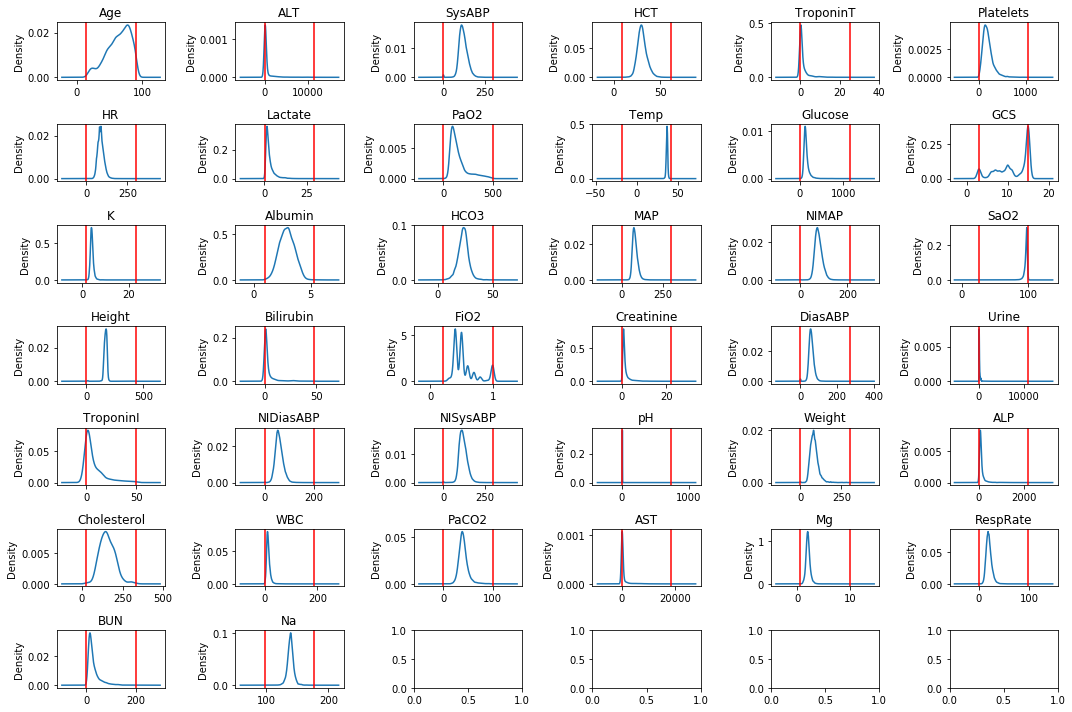

In [281]:
fig, ax = plt.subplots(nrows=7, ncols=6, figsize=(15,10))

# fig.suptitle('Univariate KDE of standardizable variables')

for index, var in enumerate(standardizable_vars):
    
    num_col = index % 6
    num_row = int(index / 6)

    axis = ax[num_row, num_col]
    axis.set_title(var)
    values = seta_data[seta_data['Parameter'] == var]['Value']
    
    values.plot.kde(ax=axis)
    
    axis.axvline(x=values.min(),color='r', label='min')
    axis.axvline(x=values.max(),color='r', label='max')
plt.tight_layout()

After I plotted the KDEs of variables, some things came to mind. 

1. Some variables really do have outliers. For example, see Temp, which is generally around the 36 - 37 range. I would guess that this is in Celsius. However, the min value is -17.8 (about 0 degrees F). The most compatible story with that data point is measurement error of some sort, unless the individual came from a really cold place initially...

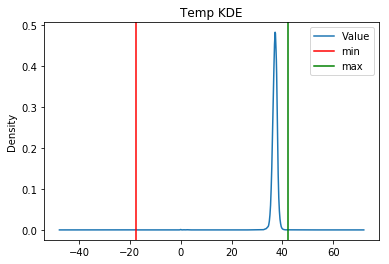

In [277]:
fig, ax = plt.subplots(1,1)
values = seta_data[seta_data['Parameter'] == 'Temp']['Value']
values.plot.kde(title='Temp KDE', ax=ax)
ax.axvline(x=values.min(),color='r', label='min')
ax.axvline(x=values.max(),color='r', label='max')
plt.legend(loc='upper right')

### MechVent is useless

This variable is the same value across all individuals. It does not offer any information extra information about the in-hospital death status of an individual. Therefore we can remove it.

In [254]:
seta_data[seta_data['Parameter'] == 'MechVent'].describe()

,PATIENT_ID,Value
count,31144.000000,31144.0
mean,137650.676342,1.0
std,2927.235050,0.0
min,132540.000000,1.0
25%,135146.000000,1.0
50%,137678.000000,1.0
75%,140166.000000,1.0
max,142673.000000,1.0


### Create cross-product

In [29]:
index = pd.MultiIndex.from_product(
    [unique_patient_ids, standardizable_vars, list(range(0, 48, WIDTH_HOURS))], 
    names = ["PATIENT_ID", "Parameter", "time_block"]
)

cross_product = pd.DataFrame(index = index).reset_index()
cross_product['Value'] = np.nan

### Merge

In [30]:
merged = pd.merge(left=cross_product, right=reset_averaged, on=['PATIENT_ID', 'Parameter', 'time_block'], how='left')
merged

,PATIENT_ID,Parameter,time_block,Value_x,Value_y
0,132539,Urine,0,NaN,166.363636
1,132539,Urine,12,NaN,80.000000
2,132539,Urine,24,NaN,177.500000
3,132539,Urine,36,NaN,271.428571
4,132539,AST,0,NaN,NaN
5,132539,AST,12,NaN,NaN
6,132539,AST,24,NaN,NaN
7,132539,AST,36,NaN,NaN
8,132539,HR,0,NaN,67.666667
9,132539,HR,12,NaN,65.416667


In [31]:
for param in standardizable_vars:
    merged.loc[
        (merged['Parameter'] == param) & (merged['Value_y'].isnull()),
        'Value_y'
    ] = seta_data[seta_data['Parameter'] == param]['Value'].mean()

In [32]:
merged['Parameter_hour_block'] = merged['Parameter'] + '_' + (merged['time_block']).astype('str')
merged

,PATIENT_ID,Parameter,time_block,Value_x,Value_y,Parameter_hour_block
0,132539,Urine,0,NaN,166.363636,Urine_0
1,132539,Urine,12,NaN,80.000000,Urine_12
2,132539,Urine,24,NaN,177.500000,Urine_24
3,132539,Urine,36,NaN,271.428571,Urine_36
4,132539,AST,0,NaN,506.284098,AST_0
5,132539,AST,12,NaN,506.284098,AST_12
6,132539,AST,24,NaN,506.284098,AST_24
7,132539,AST,36,NaN,506.284098,AST_36
8,132539,HR,0,NaN,67.666667,HR_0
9,132539,HR,12,NaN,65.416667,HR_12


In [280]:
seta_data[seta_data['Parameter'] == 'Troponini'].describe()

,PATIENT_ID,Value
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [261]:
seta_data[seta_data['Parameter'] == 'Glucose'].describe()

,PATIENT_ID,Value
count,13021.000000,13021.000000
mean,137549.376546,141.509561
std,2927.082519,67.697572
min,132539.000000,10.000000
25%,135006.000000,105.000000
50%,137489.000000,127.000000
75%,140065.000000,157.000000
max,142673.000000,1143.000000


In [262]:
seta_data[seta_data['Parameter'] == 'Temp'].describe()

,PATIENT_ID,Value
count,86405.000000,86405.000000
mean,137626.043956,37.007651
std,2899.986755,1.775174
min,132539.000000,-17.800000
25%,135103.000000,36.600000
50%,137699.000000,37.100000
75%,140077.000000,37.600000
max,142673.000000,42.100000


In [33]:
def get_predictors(
    df, 
    parameter_time_block_column='Parameter_hour_block', 
    value_column='Value_y', 
    patient_id_col='PATIENT_ID'
):
    unique_param_time_blocks = df[parameter_time_block_column].unique()
    
    collection = df[df[parameter_time_block_column] == unique_param_time_blocks[0]]
    collection[unique_param_time_blocks[0]] = collection[value_column]
    new_collection = collection[[patient_id_col, unique_param_time_blocks[0]]]
    
    for i in range(1, len(unique_param_time_blocks)):
        param_time_block_col = unique_param_time_blocks[i]
        
        data = df[df[parameter_time_block_column] == param_time_block_col].copy()
        data[param_time_block_col] = data[value_column]
        new_collection = pd.merge(
            left=new_collection, 
            right=data[
                [
                    patient_id_col, 
                    param_time_block_col
                ]
            ], 
            on=patient_id_col
        )
        
    return new_collection
        

### flattened_predictors

In [34]:
flattened_predictors = get_predictors(merged)
flattened_predictors

/Users/eddericugaddan/miniconda3/envs/icu-survival/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,PATIENT_ID,Urine_0,Urine_12,Urine_24,Urine_36,AST_0,AST_12,AST_24,AST_36,HR_0,...,GCS_24,GCS_36,Mg_0,Mg_12,Mg_24,Mg_36,Cholesterol_0,Cholesterol_12,Cholesterol_24,Cholesterol_36
0,132539,166.363636,80.000000,177.500000,271.428571,506.284098,506.284098,506.284098,506.284098,67.666667,...,14.666667,15.000000,1.500000,2.027910,1.90000,2.02791,156.51746,156.51746,156.51746,156.51746
1,132540,168.857143,100.909091,155.000000,187.500000,506.284098,506.284098,506.284098,506.284098,87.360000,...,14.666667,14.250000,3.100000,1.900000,2.02791,2.10000,156.51746,156.51746,156.51746,156.51746
2,132541,109.545455,170.500000,171.666667,60.727273,235.000000,164.000000,506.284098,506.284098,90.000000,...,5.000000,5.000000,1.900000,1.300000,1.85000,1.70000,156.51746,156.51746,156.51746,156.51746
3,132543,600.000000,400.000000,675.000000,600.000000,15.000000,506.284098,506.284098,506.284098,73.260870,...,15.000000,15.000000,2.100000,2.027910,1.90000,2.02791,156.51746,156.51746,156.51746,156.51746
4,132545,69.000000,50.600000,66.666667,62.777778,506.284098,506.284098,506.284098,506.284098,84.692308,...,15.000000,15.000000,1.500000,2.027910,1.60000,2.02791,156.51746,156.51746,156.51746,156.51746
5,132547,350.000000,80.000000,77.000000,58.750000,47.000000,162.000000,506.284098,506.284098,77.700000,...,9.600000,8.000000,1.700000,2.027910,2.30000,2.15000,212.00000,156.51746,156.51746,156.51746
6,132548,100.000000,36.600000,38.333333,86.000000,506.284098,506.284098,506.284098,506.284098,69.807692,...,15.000000,15.000000,2.027910,2.027910,2.02791,1.90000,156.51746,156.51746,156.51746,156.51746
7,132551,71.250000,36.636364,32.545455,41.428571,82.000000,506.284098,506.284098,506.284098,90.071429,...,9.500000,9.666667,3.150000,2.027910,1.60000,2.02791,156.51746,156.51746,156.51746,156.51746
8,132554,200.000000,300.000000,250.000000,120.798728,506.284098,506.284098,506.284098,506.284098,130.900000,...,15.000000,15.000000,2.027910,1.600000,1.70000,2.02791,156.51746,156.51746,156.51746,156.51746
9,132555,119.285714,85.454545,117.272727,107.272727,506.284098,506.284098,506.284098,506.284098,78.000000,...,15.000000,15.000000,2.027910,1.800000,2.02791,1.80000,156.51746,156.51746,156.51746,156.51746


In [35]:
def merge_categoricals(
    original_source_df,
    left_df,
    patient_id_col='PATIENT_ID',
    categoricals=['Gender', 'ICUType']
):
    df = pd.DataFrame()
    
    for i in categoricals:
        data = original_source_df[original_source_df['Parameter'] == i].copy()
        data[i] = data['Value']
        
        if df.shape[0] == 0:
            df = pd.merge(
                left=left_df,
                right=data[[patient_id_col, i]],
                on=patient_id_col,
                how='left'
            )
            
        else:
            df = pd.merge(
                left=df,
                right=data[[patient_id_col, i]],
                on=patient_id_col,
                how='left'
            )
            
    return df

In [36]:
complete_predictors = merge_categoricals(
    original_source_df=seta_data,
    left_df=flattened_predictors,
)

In [37]:
complete_predictors.columns

Index(['PATIENT_ID', 'Urine_0', 'Urine_12', 'Urine_24', 'Urine_36', 'AST_0',
       'AST_12', 'AST_24', 'AST_36', 'HR_0',
       ...
       'Mg_0', 'Mg_12', 'Mg_24', 'Mg_36', 'Cholesterol_0', 'Cholesterol_12',
       'Cholesterol_24', 'Cholesterol_36', 'Gender', 'ICUType'],
      dtype='object', length=155)

In [38]:
complete_predictor_cols = complete_predictors.columns[
    ~complete_predictors.columns.str.contains('Age_')
]

### full predictors

In [39]:
predictors = complete_predictors[complete_predictor_cols]
predictors

,PATIENT_ID,Urine_0,Urine_12,Urine_24,Urine_36,AST_0,AST_12,AST_24,AST_36,HR_0,...,Mg_0,Mg_12,Mg_24,Mg_36,Cholesterol_0,Cholesterol_12,Cholesterol_24,Cholesterol_36,Gender,ICUType
0,132539,166.363636,80.000000,177.500000,271.428571,506.284098,506.284098,506.284098,506.284098,67.666667,...,1.500000,2.027910,1.90000,2.02791,156.51746,156.51746,156.51746,156.51746,0.0,4.0
1,132540,168.857143,100.909091,155.000000,187.500000,506.284098,506.284098,506.284098,506.284098,87.360000,...,3.100000,1.900000,2.02791,2.10000,156.51746,156.51746,156.51746,156.51746,1.0,2.0
2,132541,109.545455,170.500000,171.666667,60.727273,235.000000,164.000000,506.284098,506.284098,90.000000,...,1.900000,1.300000,1.85000,1.70000,156.51746,156.51746,156.51746,156.51746,0.0,3.0
3,132543,600.000000,400.000000,675.000000,600.000000,15.000000,506.284098,506.284098,506.284098,73.260870,...,2.100000,2.027910,1.90000,2.02791,156.51746,156.51746,156.51746,156.51746,1.0,3.0
4,132545,69.000000,50.600000,66.666667,62.777778,506.284098,506.284098,506.284098,506.284098,84.692308,...,1.500000,2.027910,1.60000,2.02791,156.51746,156.51746,156.51746,156.51746,0.0,3.0
5,132547,350.000000,80.000000,77.000000,58.750000,47.000000,162.000000,506.284098,506.284098,77.700000,...,1.700000,2.027910,2.30000,2.15000,212.00000,156.51746,156.51746,156.51746,1.0,1.0
6,132548,100.000000,36.600000,38.333333,86.000000,506.284098,506.284098,506.284098,506.284098,69.807692,...,2.027910,2.027910,2.02791,1.90000,156.51746,156.51746,156.51746,156.51746,0.0,3.0
7,132551,71.250000,36.636364,32.545455,41.428571,82.000000,506.284098,506.284098,506.284098,90.071429,...,3.150000,2.027910,1.60000,2.02791,156.51746,156.51746,156.51746,156.51746,0.0,3.0
8,132554,200.000000,300.000000,250.000000,120.798728,506.284098,506.284098,506.284098,506.284098,130.900000,...,2.027910,1.600000,1.70000,2.02791,156.51746,156.51746,156.51746,156.51746,0.0,3.0
9,132555,119.285714,85.454545,117.272727,107.272727,506.284098,506.284098,506.284098,506.284098,78.000000,...,2.027910,1.800000,2.02791,1.80000,156.51746,156.51746,156.51746,156.51746,1.0,2.0


In [40]:
outcomes.columns

Index(['RecordID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival',
       'In-hospital_death'],
      dtype='object')

### predictors and outcome

In [41]:
predictors_and_outcome = pd.merge(
    left=predictors,
    right=outcomes[['RecordID', 'In-hospital_death']],
    left_on='PATIENT_ID',
    right_on='RecordID'
)

In [42]:
predictors_and_outcome.loc[
    predictors_and_outcome['Gender'].isnull(),
    'Gender'
] = np.round(predictors_and_outcome['Gender'].mean())

In [43]:
predictors_and_outcome[complete_predictor_cols].isnull().sum().sum()

0

In [44]:
predictors_and_outcome

,PATIENT_ID,Urine_0,Urine_12,Urine_24,Urine_36,AST_0,AST_12,AST_24,AST_36,HR_0,...,Mg_24,Mg_36,Cholesterol_0,Cholesterol_12,Cholesterol_24,Cholesterol_36,Gender,ICUType,RecordID,In-hospital_death
0,132539,166.363636,80.000000,177.500000,271.428571,506.284098,506.284098,506.284098,506.284098,67.666667,...,1.90000,2.02791,156.51746,156.51746,156.51746,156.51746,0.0,4.0,132539,0
1,132540,168.857143,100.909091,155.000000,187.500000,506.284098,506.284098,506.284098,506.284098,87.360000,...,2.02791,2.10000,156.51746,156.51746,156.51746,156.51746,1.0,2.0,132540,0
2,132541,109.545455,170.500000,171.666667,60.727273,235.000000,164.000000,506.284098,506.284098,90.000000,...,1.85000,1.70000,156.51746,156.51746,156.51746,156.51746,0.0,3.0,132541,0
3,132543,600.000000,400.000000,675.000000,600.000000,15.000000,506.284098,506.284098,506.284098,73.260870,...,1.90000,2.02791,156.51746,156.51746,156.51746,156.51746,1.0,3.0,132543,0
4,132545,69.000000,50.600000,66.666667,62.777778,506.284098,506.284098,506.284098,506.284098,84.692308,...,1.60000,2.02791,156.51746,156.51746,156.51746,156.51746,0.0,3.0,132545,0
5,132547,350.000000,80.000000,77.000000,58.750000,47.000000,162.000000,506.284098,506.284098,77.700000,...,2.30000,2.15000,212.00000,156.51746,156.51746,156.51746,1.0,1.0,132547,0
6,132548,100.000000,36.600000,38.333333,86.000000,506.284098,506.284098,506.284098,506.284098,69.807692,...,2.02791,1.90000,156.51746,156.51746,156.51746,156.51746,0.0,3.0,132548,0
7,132551,71.250000,36.636364,32.545455,41.428571,82.000000,506.284098,506.284098,506.284098,90.071429,...,1.60000,2.02791,156.51746,156.51746,156.51746,156.51746,0.0,3.0,132551,1
8,132554,200.000000,300.000000,250.000000,120.798728,506.284098,506.284098,506.284098,506.284098,130.900000,...,1.70000,2.02791,156.51746,156.51746,156.51746,156.51746,0.0,3.0,132554,0
9,132555,119.285714,85.454545,117.272727,107.272727,506.284098,506.284098,506.284098,506.284098,78.000000,...,2.02791,1.80000,156.51746,156.51746,156.51746,156.51746,1.0,2.0,132555,0


In [45]:
def strat_k_fold(df, clf, n_splits=5, predictor_cols=complete_predictor_cols, y_column_name='In-hospital_death'):
    X = df[complete_predictor_cols].values
    y = df[y_column_name]
    skf = StratifiedKFold(n_splits=n_splits)

    scores = []

    for train_index, test_index in skf.split(X, y):
        X_test, y_test = X[test_index], y[test_index]
        
        training_data = df.iloc[train_index]
        minority = training_data[training_data[y_column_name] == 1]
        majority = training_data[training_data[y_column_name] == 0]
        
        upsampled_minority = minority.sample(n=majority.shape[0], replace=True)
        
        new_training_df = pd.concat([upsampled_minority, majority])

        # Train the model via upsampling
        clf.fit(new_training_df[predictor_cols].values, new_training_df[y_column_name])

        predict_test = clf.predict(X_test)

        precision = precision_score(y_true=y_test, y_pred=predict_test)
        recall = recall_score(y_true=y_test, y_pred=predict_test)

        scores.append({
            'precision': precision,
            'recall': recall,
            'min_precis_recall': min(precision, recall)
        })
        
    return pd.DataFrame(scores)

In [56]:
rf = strat_k_fold(
    n_splits=5,
    df=predictors_and_outcome,
    clf=RandomForestClassifier(n_estimators=100)
)

,min_precis_recall,precision,recall
0,0.090090,0.714286,0.090090
1,0.153153,0.548387,0.153153
2,0.153153,0.653846,0.153153
3,0.126126,0.518519,0.126126
4,0.045455,0.555556,0.045455


In [50]:
strat_k_fold(
    n_splits=5,
    df=predictors_and_outcome,
    clf=AdaBoostClassifier(n_estimators=100)
)

/Users/eddericugaddan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,min_precis_recall,precision,recall
0,0.000000,0.000000,0.000000
1,0.311005,0.311005,0.585586
2,0.372671,0.372671,0.540541
3,0.360000,0.360000,0.567568
4,0.370370,0.370370,0.454545


In [53]:
gbc = strat_k_fold(
    n_splits=10,
    df=predictors_and_outcome,
    clf=GradientBoostingClassifier(n_estimators=100)
)

In [55]:
gbc['min_precis_recall'].mean()

0.3716074306239071